# Network embedding via GConv-AE

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a graph-convolutional autoencoder of the same latent dimension size as our image embeddings namely 1024. The GAE model will be trained on the task of reconstructing the network structure and the gene expression data. Note that we treat the embedding of the network as a preprocessing step similar to proposed spectral embedding to allow downstream tasks such as node clustering. Thus, we will train the model on the full network and not leave out e.g. any nodes for validation or testing. We will later show that the derived embeddings can be used to effectively solve a proxy node classification task for validation.

---

## 0. Environmental setup

First, we will load all required libraries.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from IPython.display import Image

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import CustomGAE, GCNEncoder

seed = 1234

plt.style.use("default")

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we will read in the regulatory graph data along side with a scRNA-seq data set and a number of hallmark geneset information. The latter two will be used to define further node features and update the correlation information for the interactions in the graph.

In [2]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/cv/spearman_sol_cv.pkl"
)
print(nx.info(spearman_interactome))

Graph named 'spearman_sol' with 249 nodes and 526 edges


<ipython-input-2-9c9a9f64858d>:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(spearman_interactome))


<IPython.core.display.Javascript object>

In [3]:
nx.shortest_path(spearman_interactome, source="CEBPA", target="ERG")

['CEBPA', 'ATF4', 'JUN', 'ERG']

<IPython.core.display.Javascript object>

In [4]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In addition to the 50 Hallmark gene sets, we also load the gene sets corresponding to pathways involved in mechanotransduction: cell cycle control, regulation of chromatin organization and actin cytoskeleton, DNA damage repair, cell death and transcription factors.

In [5]:
cc_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_cell_cycle.txt", index_col=0
    ).index
)
co_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_chrom_org.txt", index_col=0
    ).index
)
dr_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_dna_repair.txt", index_col=0
    ).index
)
cd_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/reactome_cell_death.txt", index_col=0
    ).index
)
cr_genes = set(
    pd.read_csv(
        "../../../data/other/genesets/kegg_reg_act_cytoskeleton.txt", index_col=0
    ).index
)
tfs = set(
    pd.read_csv("../../../data/other/genesets/human_tf_list.txt", index_col=0).index
)

spec_results = pd.read_csv(
    "../../../data/other/specificity_results/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/genesets/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [6]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data.transpose()),
    index=gex_data.transpose().index,
    columns=gex_data.transpose().columns,
).transpose()

<IPython.core.display.Javascript object>

In [7]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["sc_gex"] = node[-1]["sc_gex"]
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we transform the graph into a data object complient with the used pytorch_geometric framework to learn the graph embeddings.

In [8]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))
graph_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(graph_data)

<IPython.core.display.Javascript object>

---
---

## 3. Node embeddings


After having finally prepared the data, we can now start inferring node embeddings from the data. To assess the stability of the latent spaces we will train a two-layer GAE with a four-layer feature decoder using 5 different random initilaization for a maximum of 1000 epochs until the training loss no longer goes down.


After training, we assess the similarity between the inferred latent spaces by pairwise comparing the hierarchical co-clustering of the inferred spaces pairwise using the adjusted mutual information.

---

##### Hallmark-GEX GAE (adjacency & feature reconstruction) with link splitting

We train the model on the adjacency and feature reconstruction task to monitor the model performance we split the existing links into 0.7 for training, 0.1 for validation and 0.2 for training. The training is early stopped if the performance of the link prediction task does no longer improve as measured by the BCELoss.

In [8]:
seeds = [1234, 2345, 3456, 4567]

<IPython.core.display.Javascript object>

Latent dim: 1024


 27%|██▋       | 5328/20000 [02:07<05:51, 41.75it/s]


Training stopped after 5329 epochs
Best model found at epoch 5227
------------------------------------------------------------
TEST AUC: 0.9589485470524488 AP: 0.41005623640376704
TRAIN loss: 0.9496966600418091
VAL loss: 0.9505578875541687
TEST loss: 1.0113705396652222
TEST AUC: 0.9480272108843537 	 AP: 0.9380871365916346


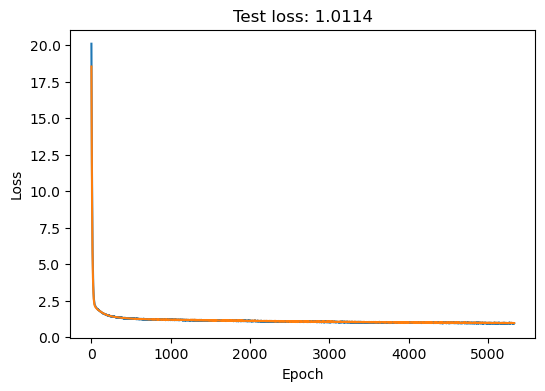

 32%|███▏      | 6470/20000 [02:35<05:25, 41.52it/s]


Training stopped after 6471 epochs
Best model found at epoch 6369
------------------------------------------------------------
TEST AUC: 0.9608729900213604 AP: 0.4049749865691627
TRAIN loss: 0.9380260705947876
VAL loss: 0.940141499042511
TEST loss: 1.005181074142456
TEST AUC: 0.9485714285714286 	 AP: 0.9368882074410485


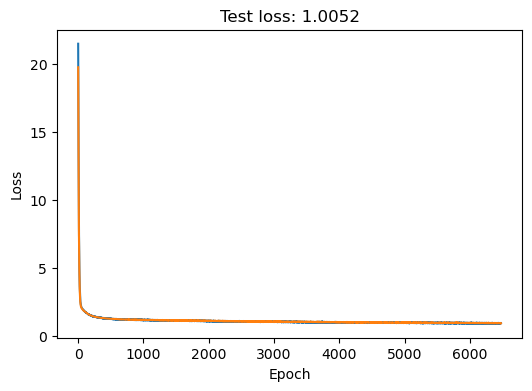

 32%|███▏      | 6434/20000 [02:37<05:31, 40.94it/s]


Training stopped after 6435 epochs
Best model found at epoch 6333
------------------------------------------------------------
TEST AUC: 0.9605405879441997 AP: 0.4134572195008776
TRAIN loss: 0.9590480327606201
VAL loss: 0.941459059715271
TEST loss: 1.0028361082077026
TEST AUC: 0.9464852607709751 	 AP: 0.9401097060669853


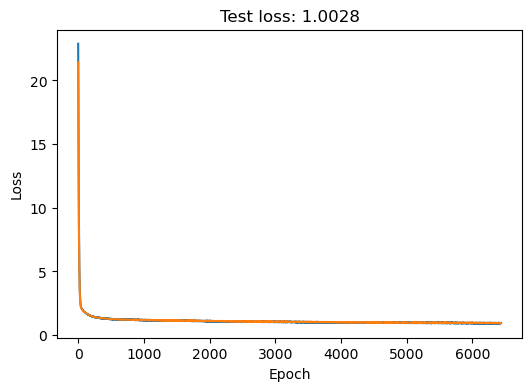

 26%|██▌       | 5140/20000 [02:10<06:16, 39.50it/s]


Training stopped after 5141 epochs
Best model found at epoch 5039
------------------------------------------------------------
TEST AUC: 0.9480308943191285 AP: 0.3552031736812248
TRAIN loss: 0.9696679711341858
VAL loss: 0.9783133268356323
TEST loss: 1.0355244874954224
TEST AUC: 0.934875283446712 	 AP: 0.9277949516828338


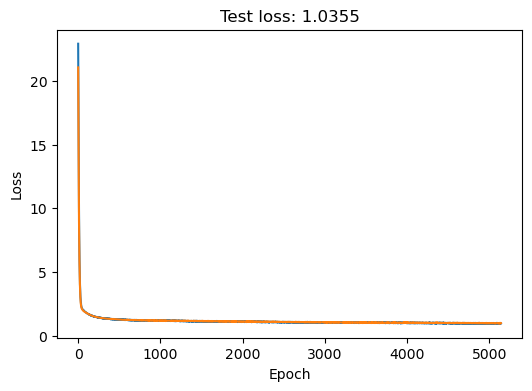

<IPython.core.display.Javascript object>

In [23]:
node_feature_key = "sc_gex_hallmark"
edge_weight_key = None

print("Latent dim: {}".format(1024))
latents_dict_hallgexgae_feat = get_gae_latents_for_seed(
    graph_data=graph_data,
    seeds=seeds,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    input_dim=1176,
    latent_dim=1024,
    hidden_dim=1024,
    n_epochs=20000,
    lr=0.00001,
    split_type="link",
    reconstruct_features=True,
    feature_decoder_params={
        "latent_dim": 1024,
        "output_dim": 1176,
        "hidden_dims": [1024, 1024, 1024],
    },
    feat_loss=torch.nn.L1Loss(),
    alpha=1,
    beta=2,
    plot_loss=True,
    early_stopping=100,
    use_full_graph=False,
    neg_edge_ratio=1.0,
)

100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


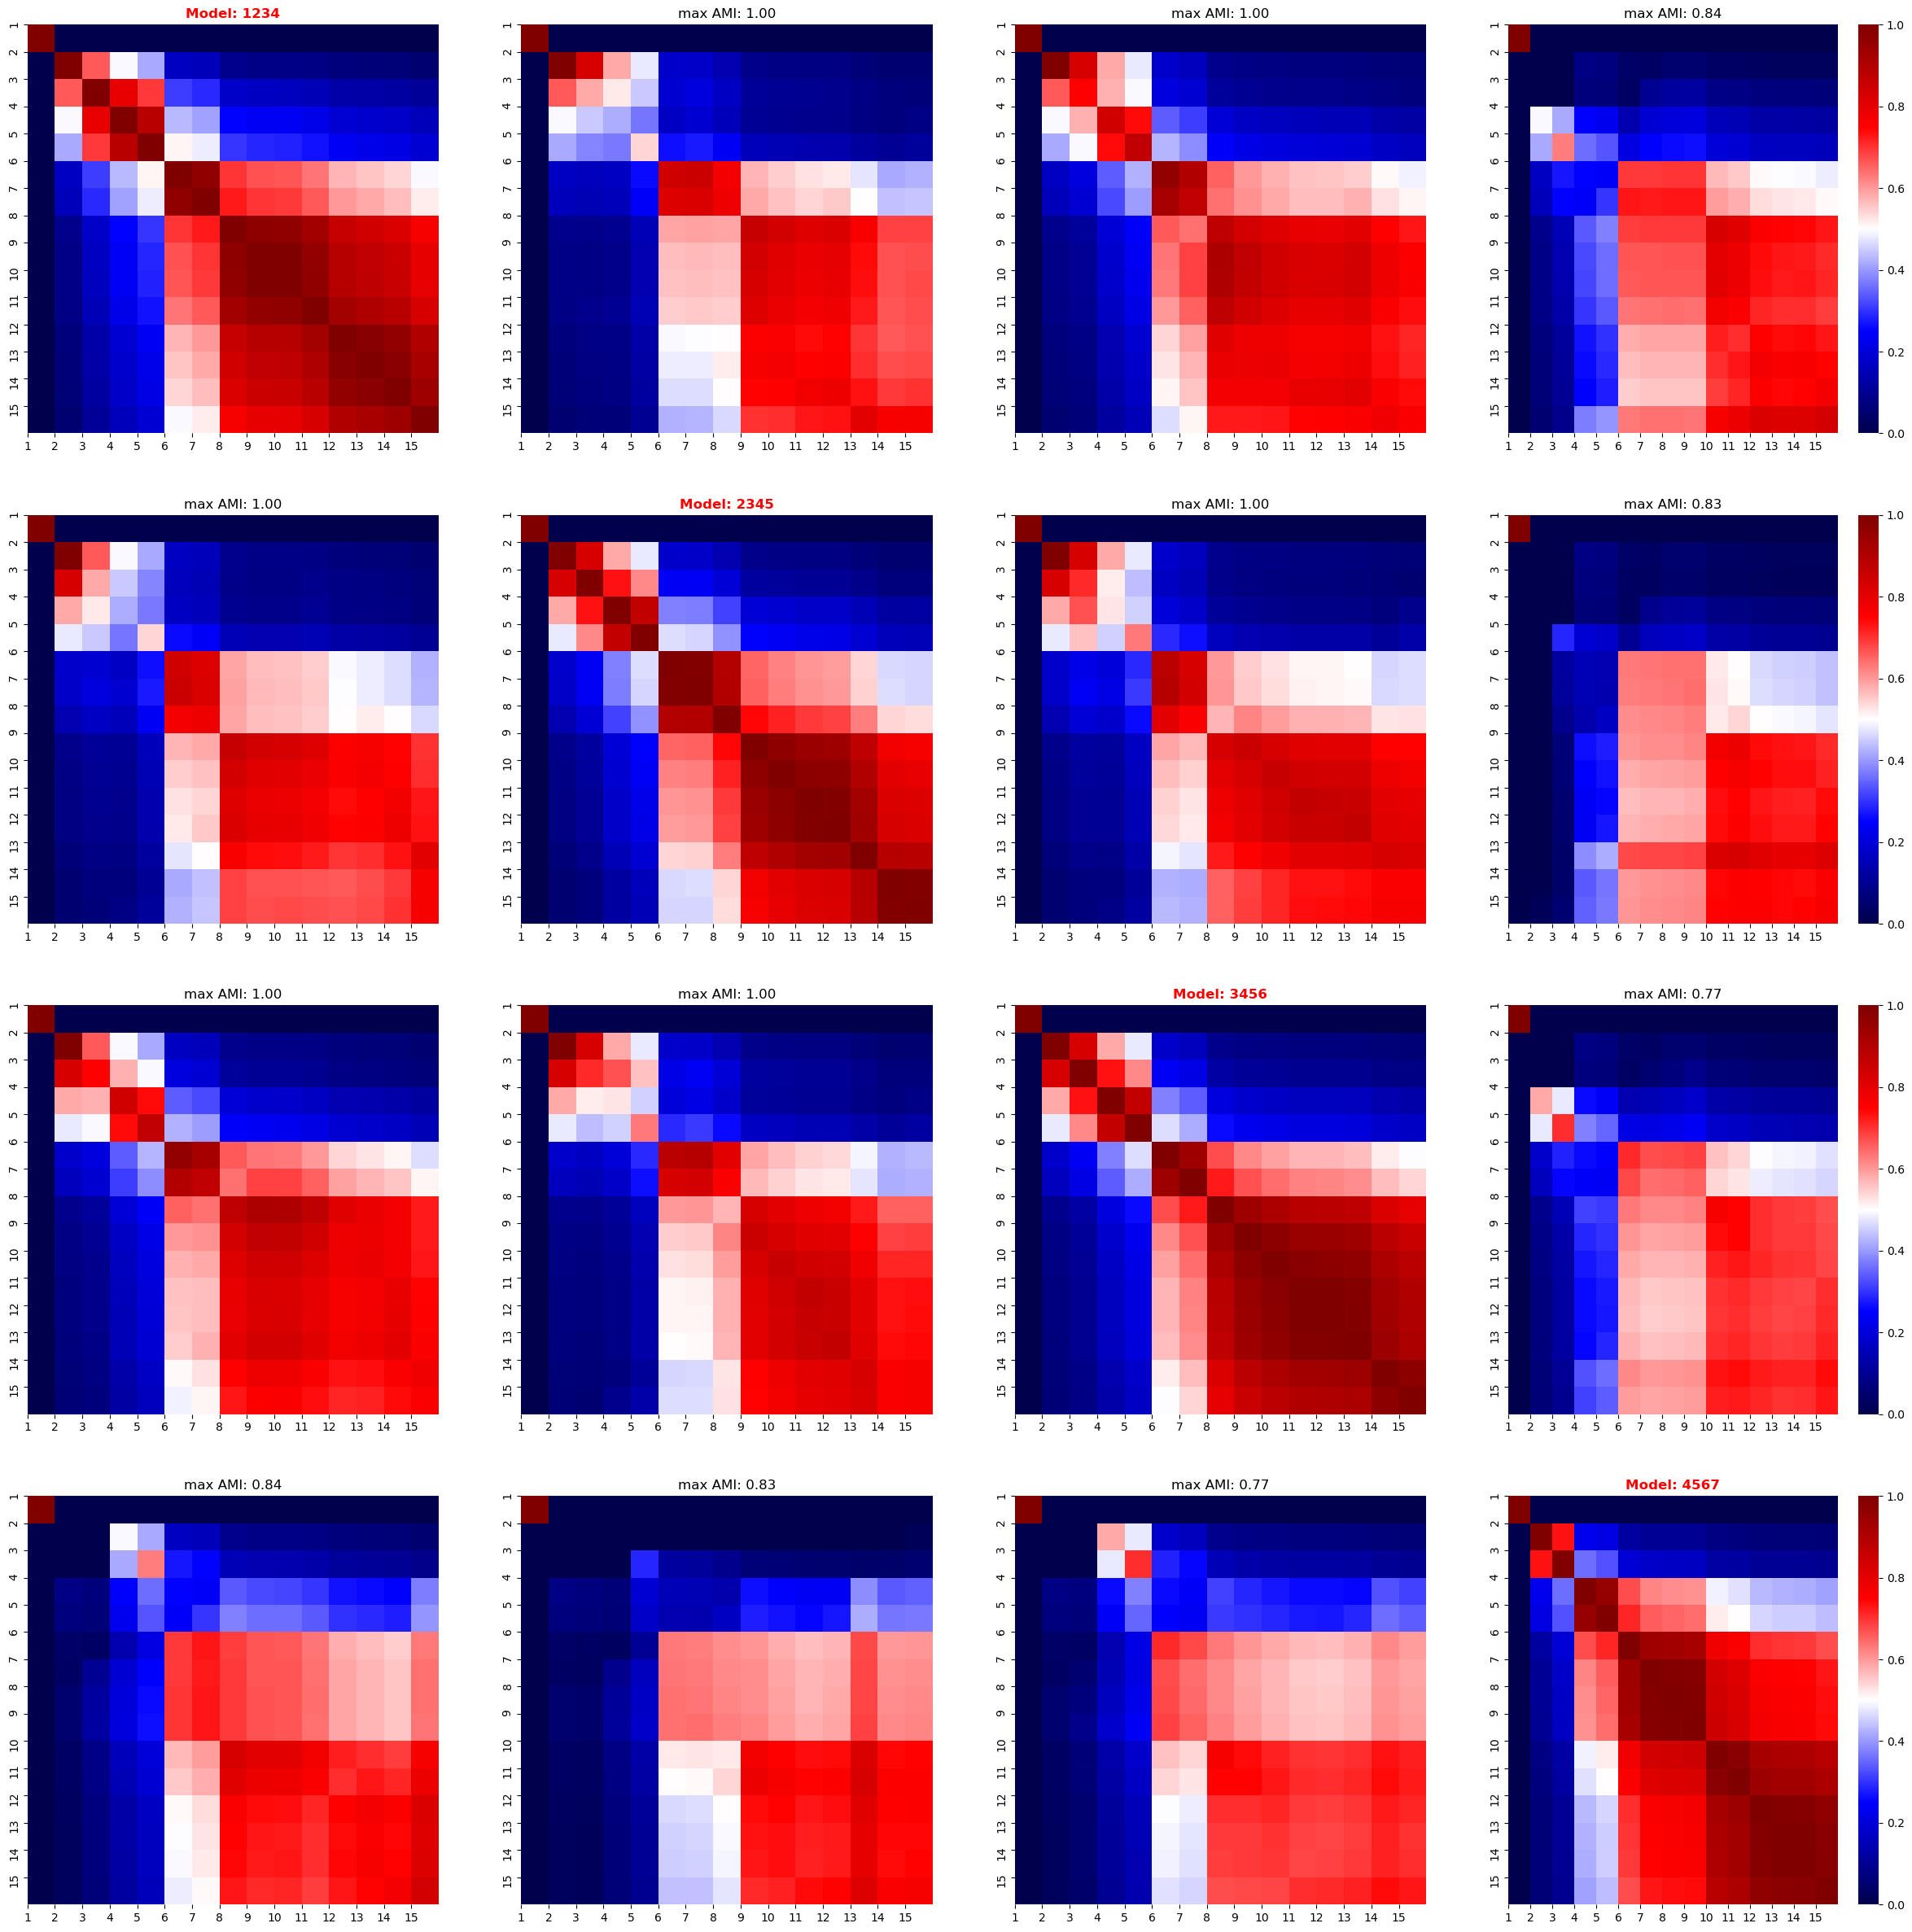

<IPython.core.display.Javascript object>

In [24]:
stability_amis_hallgexgae_feat = stability_cocluster_screen(
    latents_dict_hallgexgae_feat, linkage="average", affinity="euclidean"
)
plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


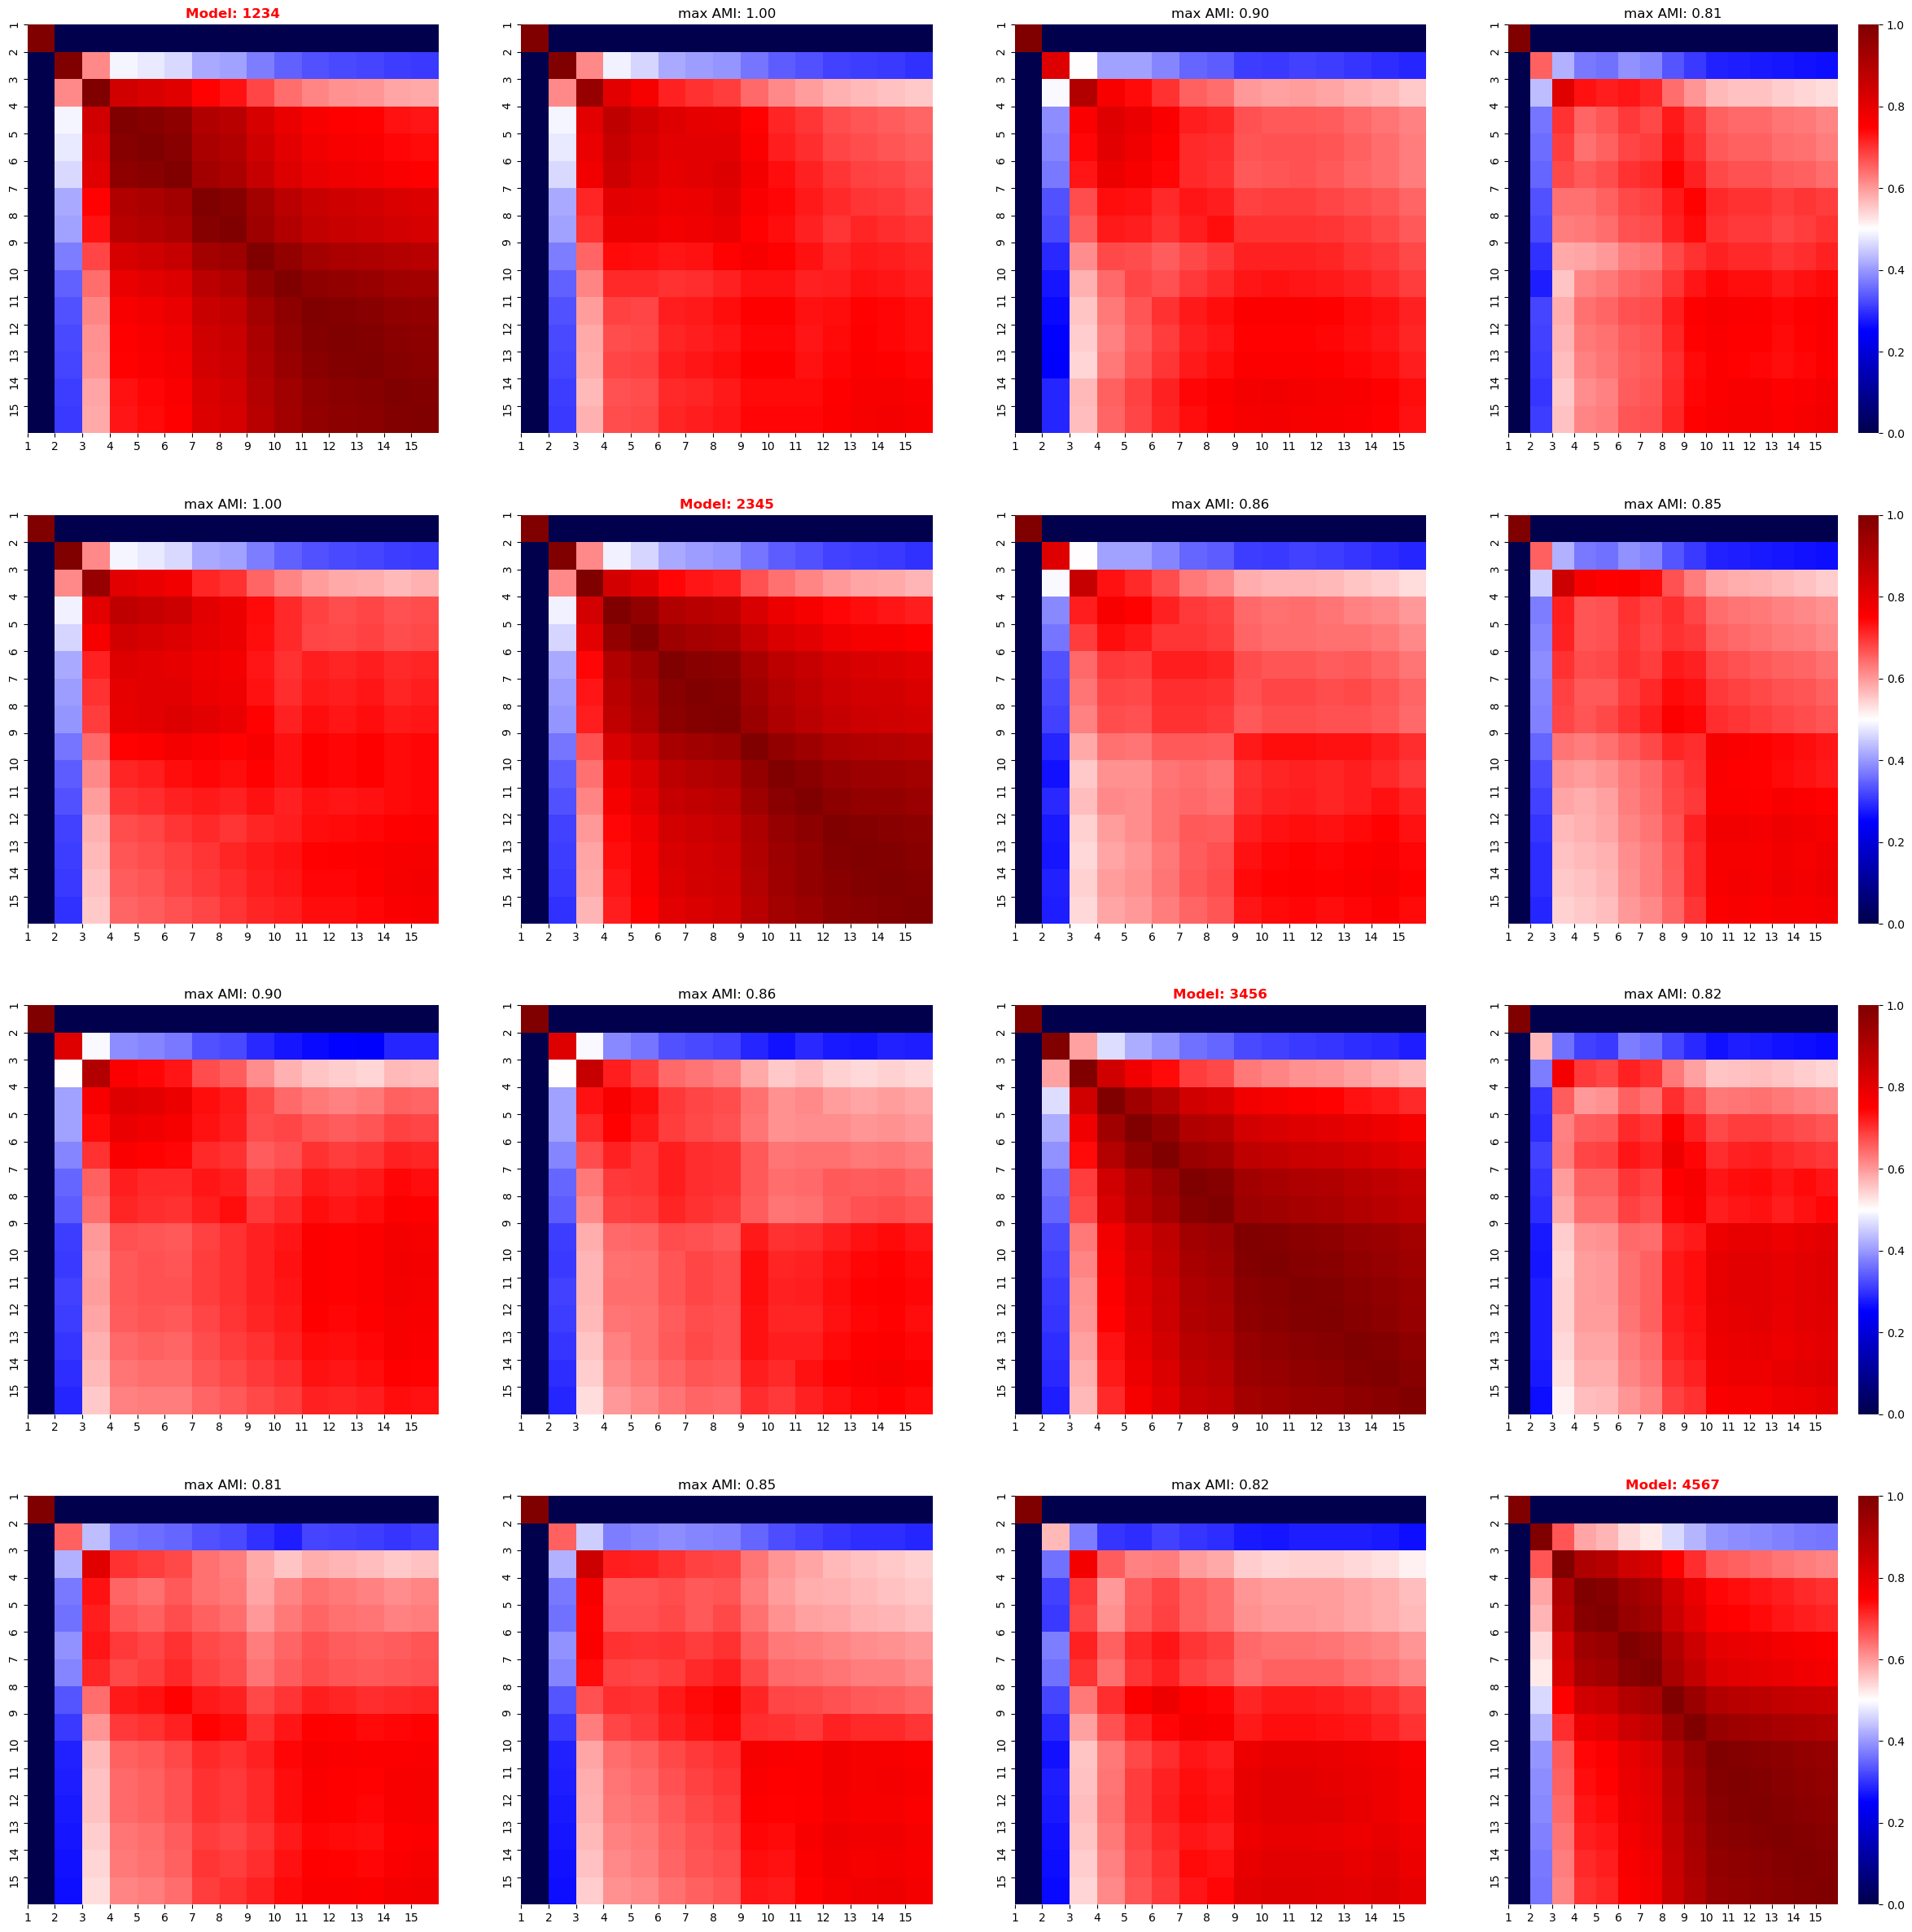

<IPython.core.display.Javascript object>

In [25]:
stability_amis_hallgexgae_feat = stability_cocluster_screen(
    latents_dict_hallgexgae_feat, linkage="average", affinity="cosine"
)
plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

The plot above suggests that while there exists differences between the inferred latent spaces. The adjusted mutual information is fairly high and the observed structure of the heatmaps on the off-diagnal locations of the above pair-plots look faily similar to the ones on the diagnol suggesting a significant overlap of shared structure.

---

### 3.3. Analyses of the inferred node embeddings

As discussed earlier, we will select the embeddings obtained from the previously described model as the final embeddings of the nodes in our network. We now will visualize and analyze the node embeddings with respect to their clustering to validate that e.g. genes which are known to function together co-cluster in the embedding space.

#### Visualization of the inferred latent space

In [26]:
latents = latents_dict_hallgexgae_feat[1234]

<IPython.core.display.Javascript object>

In [27]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [28]:
latents = pd.DataFrame(latents, index=node_names)

<IPython.core.display.Javascript object>

In [25]:
embs = TSNE(
    random_state=1234,
    perplexity=int(np.sqrt(len(latents))) + 1,
    init="pca",
    learning_rate="auto",
).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne_0", "tsne_1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

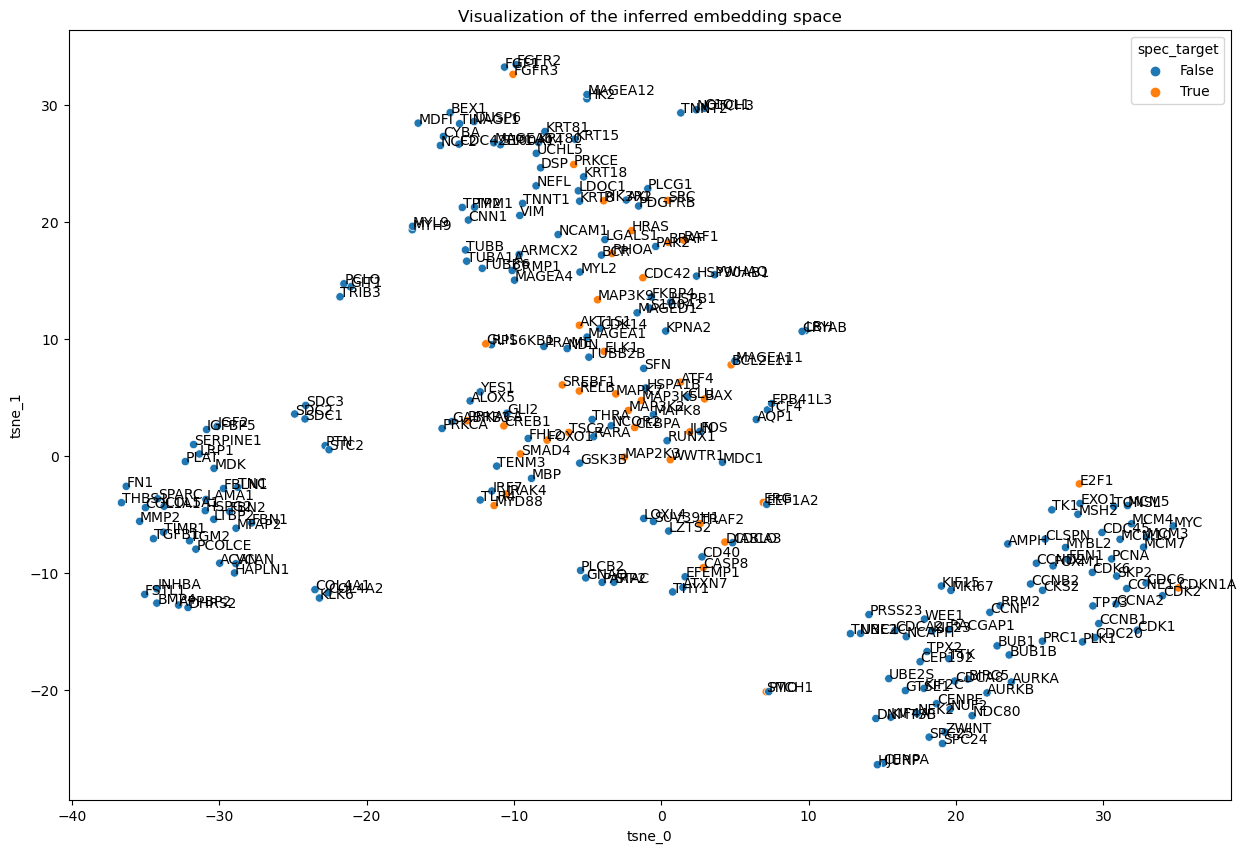

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(
    data=embs, x="tsne_0", y="tsne_1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne_0"]),
    np.array(embs.loc[:, "tsne_1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred embedding space")
plt.show()

#### Clustering of the embedding space

We will now perform a cluster analyses using hierarchical clustering based on the euclidean distances of the individual node embeddings and average linkage.

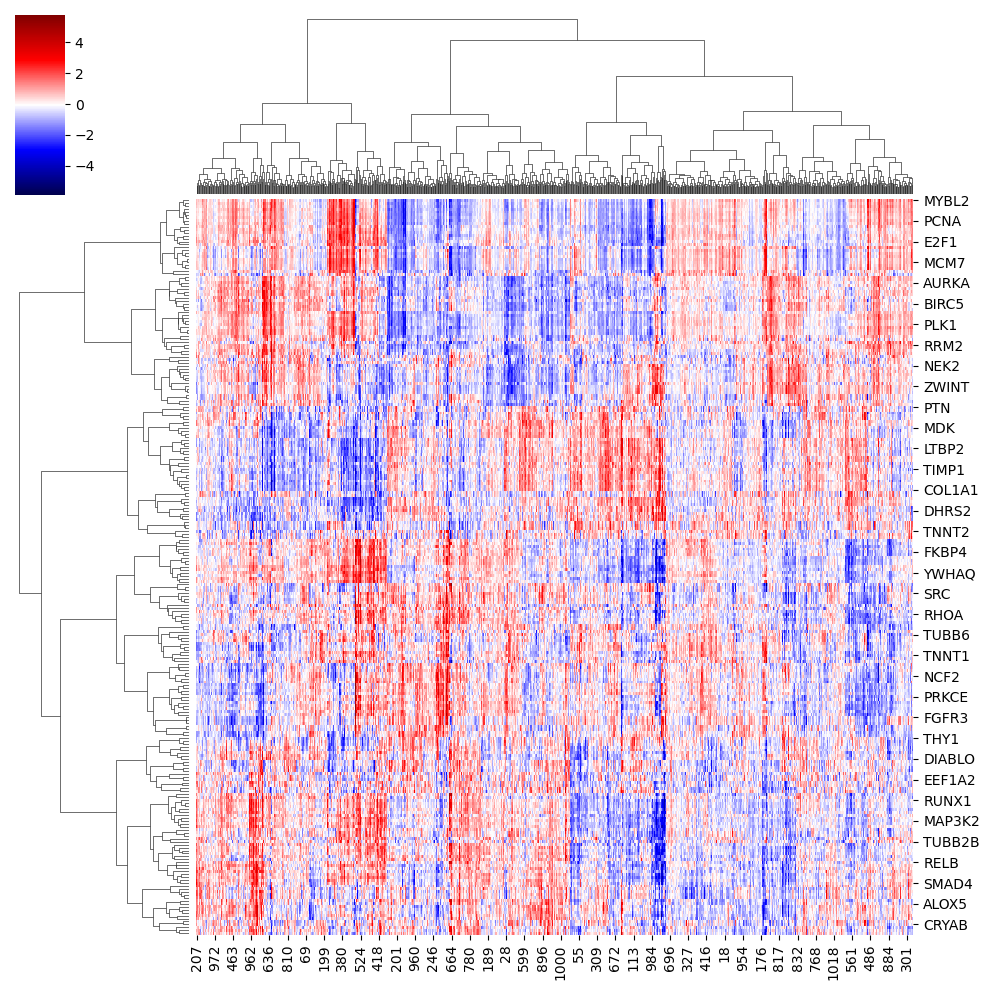

<IPython.core.display.Javascript object>

In [31]:
ax = sns.clustermap(
    latents,
    figsize=[10, 10],
    z_score=0,
    metric="euclidean",
    method="ward",
    cmap="seismic",
)

To better understand the clustering of the latent space, we will run a KMeans clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

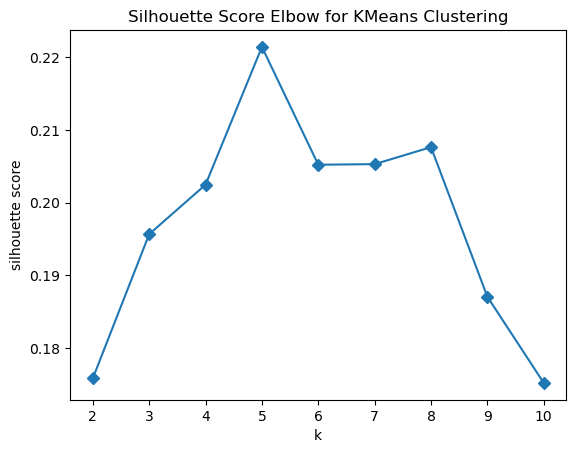

<IPython.core.display.Javascript object>

In [32]:
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(
    model, k=10, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(latents)
ax = visualizer.show()

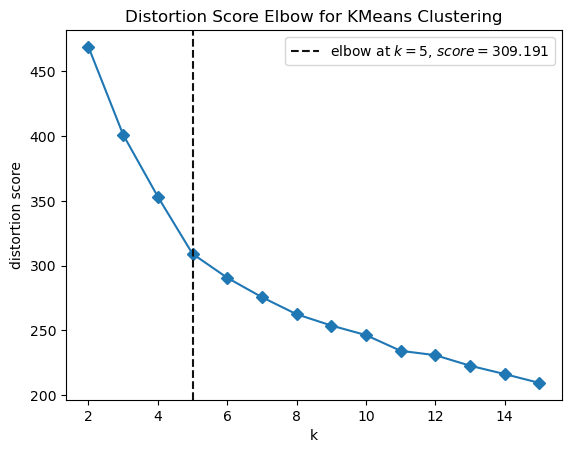

<IPython.core.display.Javascript object>

In [33]:
visualizer = KElbowVisualizer(
    model, k=15, metric="distortion", timings=False, locate_elbow=True
)

visualizer.fit(latents)
ax = visualizer.show()

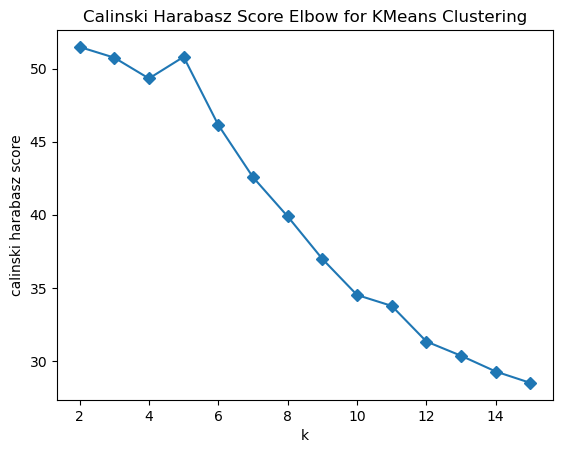

<IPython.core.display.Javascript object>

In [34]:
visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(latents)
ax = visualizer.show()

When looking at computed cluster scores, we find that the maximum Calinski-Harabasz score is reached for a solution of k=5 clusters, which also matches the elbow of the distortion score. Thus, we decide to cluster the inferred latent space into 5 distinct clusters.

Next, we aim to characterize the meaning of these clusters using a gene ontology analysis to identify the four GO terms associated with the clusters that have the lowest FDR. Clusters with no significant GO terms will be marked accordingly.

In [20]:
print(list(spearman_interactome.nodes()))
#latents = node_embs.copy()

['PTN', 'KLK6', 'AURKB', 'TRAF2', 'TNNC1', 'KRT80', 'SDC1', 'SPC24', 'MCM3', 'TUBB', 'FHL2', 'MAGED1', 'TNNT2', 'CDC20', 'COL5A1', 'NUF2', 'PLAT', 'TINAGL1', 'APPBP2', 'C1QL1', 'CNN1', 'GSK3B', 'IRF7', 'CEP192', 'BUB1', 'VIM', 'INHBA', 'SMAD4', 'HRAS', 'HSPG2', 'AURKA', 'CENPA', 'ATXN7', 'TRIB3', 'COL4A1', 'MYH9', 'PCOLCE', 'BMP4', 'CYBA', 'THBS1', 'ELK1', 'ARMCX2', 'CDC6', 'RUNX1', 'MAPK7', 'BUB1B', 'NEK2', 'NEFL', 'UCHL5', 'FGF1', 'SFN', 'FOXO1', 'NCAM1', 'YWHAQ', 'FBN2', 'GTSE1', 'ERG', 'CDCA3', 'UBE2C', 'TP73', 'SPC25', 'EEF1A2', 'MDK', 'CCND2', 'KRT15', 'PRKCE', 'BEX1', 'HJURP', 'DSP', 'TCF4', 'HK2', 'NDN', 'MSH2', 'CKS2', 'GABRB3', 'SMO', 'E2F1', 'THRA', 'PDGFRB', 'ATF4', 'S100A14', 'EPB41L3', 'PRSS23', 'PARP2', 'PRKCA', 'TUBB2B', 'MCM10', 'FN1', 'CDC42', 'NCF2', 'RHOA', 'MDC1', 'RPS6KB1', 'SDC3', 'VCAN', 'PLK1', 'MKI67', 'TPM2', 'HSPA1B', 'FOXM1', 'LBH', 'KIF23', 'NOTCH3', 'GNAQ', 'CENPE', 'KIF2C', 'MAP2K3', 'KRT8', 'TENM3', 'MAPK8', 'TNC', 'PRC1', 'MYC', 'LAMA1', 'PLCG1', 'RRM2

<IPython.core.display.Javascript object>

In [21]:
model = KMeans(n_clusters=5, random_state=seed)
cluster_labels = model.fit_predict(latents)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(latents.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(set(v).intersection(spec_orf_targets))))
    print("")

Cluster 0: ['CDKN1A', 'E2F1']

Cluster 1: ['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'CASP8', 'CEBPA', 'CREB1', 'DIABLO', 'ELK1', 'ERG', 'FOXO1', 'GLI1', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAPK7', 'MYD88', 'PRKACA', 'RELB', 'SMAD4', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']

Cluster 2: ['SMO']

Cluster 3: ['BRAF', 'CDC42', 'FGFR3', 'HRAS', 'MAP3K9', 'PIK3R2', 'PRKCE', 'RAF1', 'RHOA']

Cluster 4: []



<IPython.core.display.Javascript object>

In [40]:
cluster_df = pd.DataFrame(cluster_labels, columns=["cluster"], index=latents.index)
tmp = cluster_df.loc[
    set(list(cluster_df.index)).intersection(spec_orf_targets)
].sort_index()
tmp = list(np.array(tmp).flatten())
print(tmp)

[1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>

In [42]:
print(sorted(list(set(list(cluster_df.index)).intersection(spec_orf_targets))))

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'DIABLO', 'E2F1', 'ELK1', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

The plot below shows the results of the GO analysis of the clustering solution. Note that we limit the visualization to the top-4 GO terms associated with a biological process that have the lowest FDR.

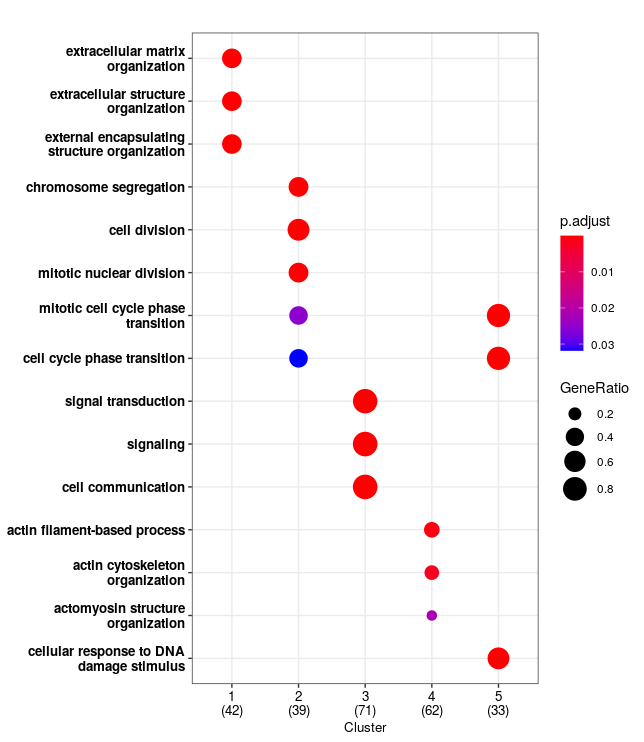

<IPython.core.display.Javascript object>

In [8]:
Image(filename="../../../data/figures/reg_space_5means_go_newnodeset.png")

In [22]:
cluster_label_dict = {
    4: "ECM interactions",
    2: "Cell cycle control",
    1: "Signal transduction",
    3: "Cytoskeletal organization",
    0: "DNA damage response",
}

<IPython.core.display.Javascript object>

In [23]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")


embs = TSNE(
    random_state=1234, perplexity=int(np.sqrt(len(latents))) + 1, init="pca", learning_rate="auto"
).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne_0", "tsne_1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()


embs["cluster"] = cluster_labels
embs["cluster"] = embs.cluster.map(cluster_label_dict)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

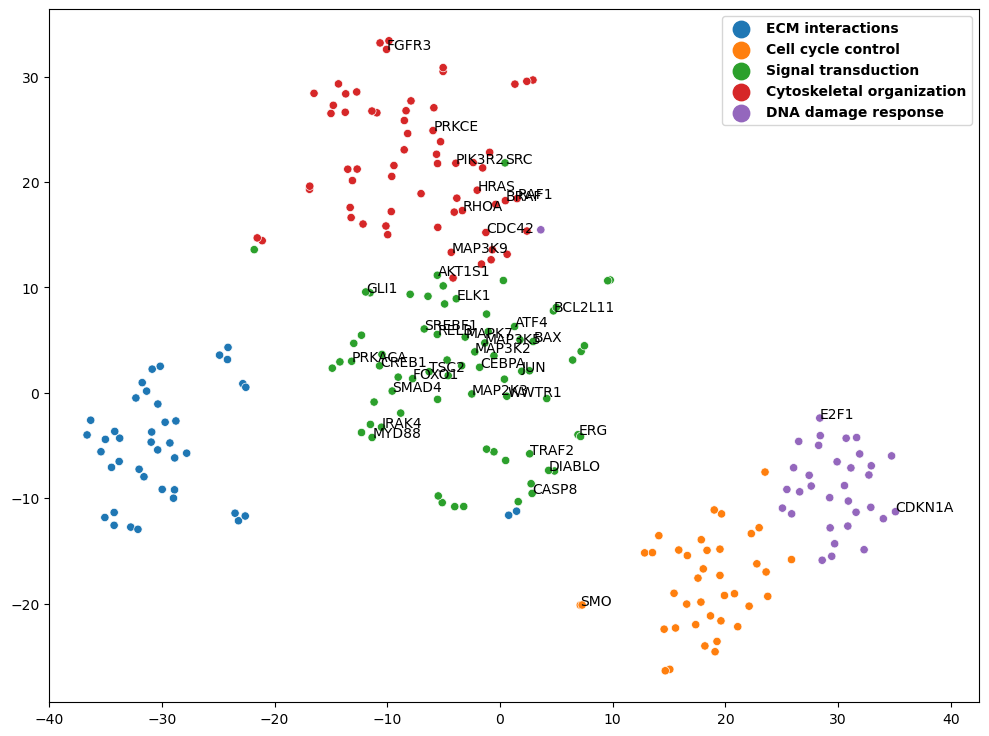

<IPython.core.display.Javascript object>

In [32]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[12, 9])
ax = sns.scatterplot(data=embs, x="tsne_0", y="tsne_1", cmap="viridis", hue="cluster")
ax.legend(loc="upper right", prop={"size": 10, "weight": "bold"})
for lh in ax.get_legend().legendHandles:
    lh.set_alpha(1)
    lh._sizes = [140]
# ax.set_title("tSNE plot of the regulatory embeddings")
ax.set_xlabel("")
ax.set_ylabel("")
label_point(
    np.array(embs.loc[embs.spec_target == True, "tsne_0"]),
    np.array(embs.loc[embs.spec_target == True, "tsne_1"]),
    np.array(embs.loc[embs.spec_target == True].index).astype("str"),
    ax=ax,
)
ax.set_xlim([-40, 42.5])
# ax.set_ylim([-25, 25])
plt.show()

We see that the two major clusters are gene involved in cell-cycle regulation and transcriptional and apoptotic regulation.

---

### 3.4. Data export

We will now save the inferred node embeddings for later analyses.

In [36]:
latents.to_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graphrecon_mask_loss_newnodeset.csv"
)

<IPython.core.display.Javascript object>

In [44]:
cluster_results = embs.loc[:, "cluster"]
cluster_results.to_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2_gexrecon_1graph_recon_mask_loss_newnodeset_clusters.csv"
)

<IPython.core.display.Javascript object>

---

## 4. Translational analyses

We will now look at the co-clustering of those embeddings with the ones we obtain for the imaging space.

### 4.1. Read in data

First, we read in the previously computed network embedding serving as a proxy for the regulatory space in U2OS cells as well as the respective image embeddings which we use to model the structural space of those cells. Since, we have many images corresponding to a single over-expression condition we will use their mean embeddings as a description of the structural profile in U2OS cells associated with the respective single-gene OE condition.

In [19]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graphrecon_mask_loss_newnodeset.csv",
    index_col=0,
)

<IPython.core.display.Javascript object>

In [131]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = img_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
img_embs = img_embs.groupby(by="labels").mean()

<IPython.core.display.Javascript object>

### 4.2. Translation analysis

Next, we will assess the co-clustering of our inferred estimates of the structural and the regulatory space using a similar approach as described earlier to assess the structural similarity of the different network embeddings.

In [142]:
node_embs = latents

<IPython.core.display.Javascript object>

In [143]:
shared_nodes = set(img_embs.index).intersection(node_embs.index)

<IPython.core.display.Javascript object>

In [170]:
ami_img_node = compute_ami_matrix(
    img_embs.loc[shared_nodes],
    node_embs.loc[shared_nodes],
    affinity=["euclidean", "euclidean"],
    linkage="complete",
)

<IPython.core.display.Javascript object>

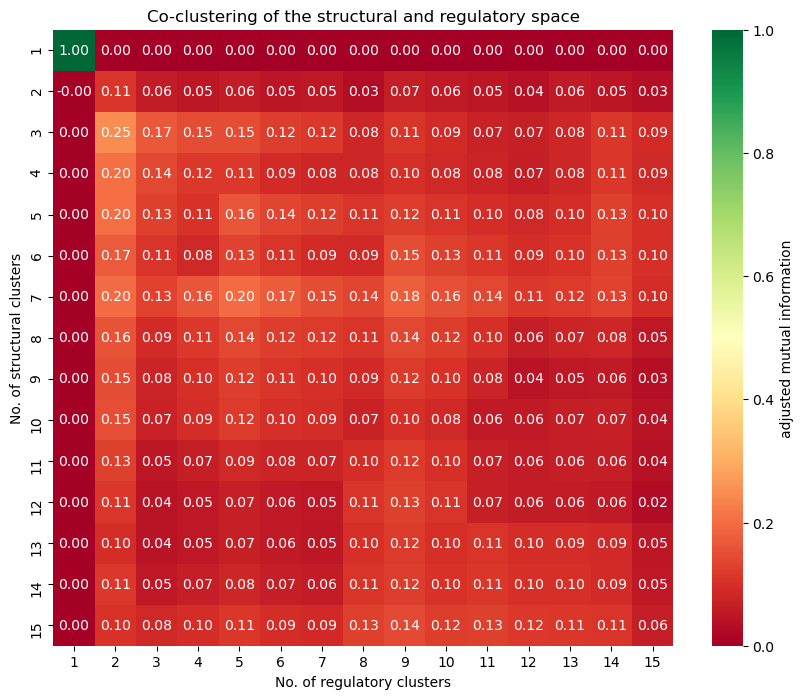

<IPython.core.display.Javascript object>

In [171]:
fig, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(
    ami_img_node,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(15)])
ax.set_yticklabels([i + 1 for i in range(15)])
ax.set_xlabel("No. of regulatory clusters")
ax.set_ylabel("No. of structural clusters")
ax.set_title("Co-clustering of the structural and regulatory space")
plt.show()

In [148]:
cmap_data = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/gex/cmap/filtered_l5_data_u2os.csv",
    index_col=0,
)
cmap_data.head()
cmap_data = cmap_data.groupby("target").mean()
cmap_data

,CAMSAP2,PPP2R5A,CISD1,AKAP8,TMEM109,CHAC1,FOS,ORC1,AARS,MLLT11,...,ABCF1,SERPINE1,HLA-DMA,STK10,BLCAP,ASCC3,KDELR2,HIST2H2BE,MELK,SMARCA4
target,,,,,,,,,,,,,,,,,,,,,
ACVR1B,-0.655167,-0.396750,0.331467,0.210683,0.514150,-0.159000,0.624683,-0.190117,-0.085033,0.303417,...,0.199633,0.505433,0.127283,-0.197517,0.116783,0.468083,-0.115700,-0.703183,1.093517,0.179967
ADAM17,0.254800,0.040200,-0.251950,-0.434400,0.077000,-0.014950,-0.036950,-1.055250,0.300150,0.283800,...,0.217550,-0.172350,-0.335450,-0.569100,-0.741500,0.278500,-0.040350,0.719400,-0.134250,0.859750
AKT1,-0.316983,-1.004300,0.054283,-0.170033,0.121950,-0.199067,-0.306967,-0.229017,-0.404150,0.809800,...,0.043800,0.421250,0.863717,-0.351917,0.348333,0.346150,0.200217,-0.373067,-0.345750,0.461600
AKT1S1,-0.279350,-1.578925,-0.231600,0.484600,-0.066150,-0.453650,-0.468950,0.062200,-1.380075,-0.571250,...,-0.044450,1.642675,-0.222175,2.352925,-0.783325,0.478025,-0.321900,-0.508475,0.145675,1.385150
AKT2,-1.120450,0.011550,0.044450,1.121250,0.783850,-0.329950,-0.623600,-0.507700,-0.070500,1.409200,...,0.031650,1.131150,0.135300,1.086600,-0.540200,-0.258800,1.202250,-0.479050,0.251100,0.092850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHL,-0.502725,-0.113050,-0.291275,-0.217225,0.385100,0.217425,1.646875,-0.902000,0.434925,-0.120350,...,0.002075,0.539775,0.200750,-0.185000,0.727400,0.230875,0.156575,-0.303300,0.091225,-0.333700
WWTR1,-1.703150,0.548250,-0.748500,0.202400,-0.669150,-0.449450,-0.785300,-0.334300,-0.990450,0.369600,...,-0.371200,-0.655400,0.337250,-0.421750,0.015400,0.365000,0.486250,-0.554250,0.632500,1.310250
XBP1,0.375625,-0.952575,0.676050,0.653825,-0.211475,-0.128275,0.201275,0.601525,0.375450,0.826475,...,-0.196100,-0.027050,-0.292575,0.332575,-0.223800,-0.703625,0.691350,0.388600,0.238750,-0.030825


<IPython.core.display.Javascript object>

In [165]:
ami_img_cmap = compute_ami_matrix(
    img_embs.loc[shared_nodes.intersection(cmap_data.index)],
    cmap_data.loc[shared_nodes.intersection(cmap_data.index)],
    linkage="average",
    affinity=["euclidean", "cosine"],
)

<IPython.core.display.Javascript object>

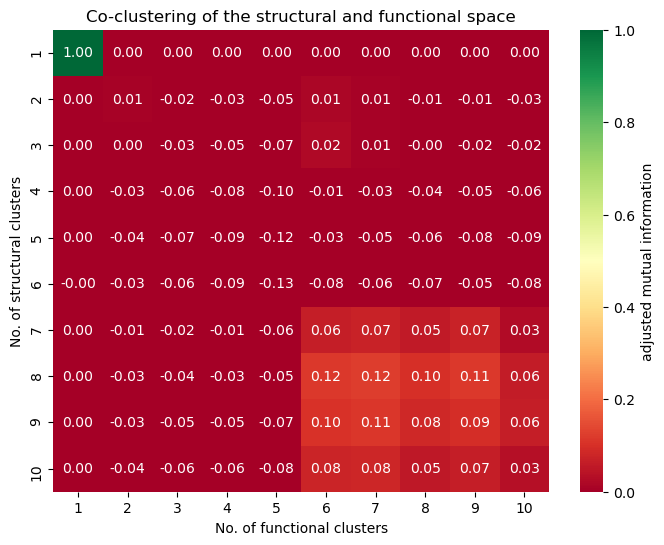

<IPython.core.display.Javascript object>

In [166]:
fig, ax = plt.subplots(figsize=[8, 6])
sns.heatmap(
    ami_img_cmap[:10, :10],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(10)])
ax.set_yticklabels([i + 1 for i in range(10)])
ax.set_xlabel("No. of functional clusters")
ax.set_ylabel("No. of structural clusters")
ax.set_title("Co-clustering of the structural and functional space")
plt.show()

---

In [162]:
ami_node_cmap = compute_ami_matrix(
    node_embs.loc[shared_nodes.intersection(cmap_data.index)],
    cmap_data.loc[shared_nodes.intersection(cmap_data.index)],
    linkage="average",
    affinity=["euclidean", "cosine"],
)

<IPython.core.display.Javascript object>

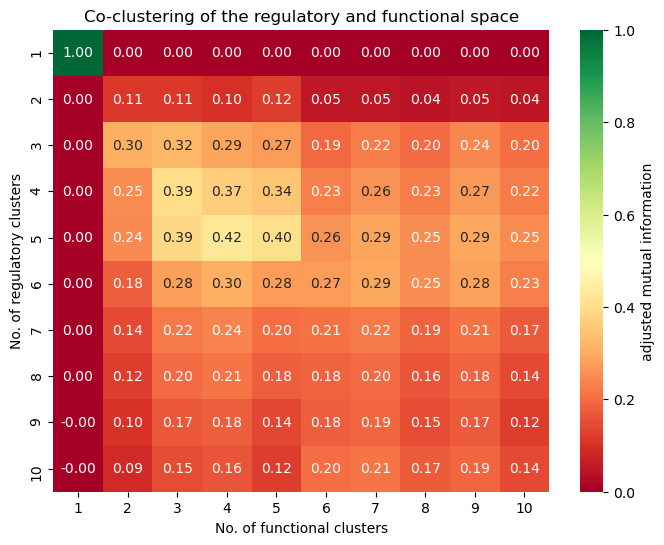

<IPython.core.display.Javascript object>

In [163]:
fig, ax = plt.subplots(figsize=[8, 6])
sns.heatmap(
    ami_node_cmap[:10, :10],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(10)])
ax.set_yticklabels([i + 1 for i in range(10)])
ax.set_xlabel("No. of functional clusters")
ax.set_ylabel("No. of regulatory clusters")
ax.set_title("Co-clustering of the regulatory and functional space")
plt.show()